In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
import time
import eos
import tov
import tov_tide

In [2]:
dkm = 1.3234e-6 #conversion from Mev/fm^3 to km^-2
conv=197.33**3             #in MeV/fm3
# Fiducial minimum pressure
pcmin = 1.33e-6

# This function returns Energy and pressure array given given eos parameters
#and if eos is not montonic returns nan
def EoS(theta):
    L0,Ksym = theta[0],theta[1]
    index, nb, pressure, energy, cs, icc = eos.eos(L0,Ksym,1.6,3.,6.2,3.7,2.4,2.6)
    nb = nb[0:index-1]
    pressure = pressure[0:index-1]
    energy = energy[0:index-1]
    cs = cs[0:index-1]
    pres=pressure*dkm
    ener=energy*dkm
    return ener, pres, nb, cs, icc

# Find the first maxima
def find_first_maxima(arr):
    for i in range(1, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            return i, arr[i]  # Return the index and the value of the first maxima
    max_index = np.argmax(arr)
    return max_index, arr[max_index]

def get_MR_pc(theta,pc):
    M=[]
    R=[]
    for i in pc:
        L0,Ksym = theta[0],theta[1]
        index, nb, pressure, energy, cs, icc = eos.eos(L0,Ksym,1.6,3.,6.2,3.7,2.4,2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres=pressure*dkm
        ener=energy*dkm
        m,r = tov.tov(ener,pres,[i])
        M.append(m)
        R.append(r)
    return M,R
    
def get_MRL_pc(theta,pc):
    M=[]
    R=[]
    L=[]
    for i in pc:
        L0,Ksym = theta[0],theta[1]
        index, nb, pressure, energy, cs, icc = eos.eos(L0,Ksym,1.6,3.,6.2,3.7,2.4,2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres=pressure*dkm
        ener=energy*dkm
        m,r,td = tov_tide.tov_tide(ener,pres,[i])
        M.append(m)
        R.append(r)
        L.append(td)
    return M,R,L

In [6]:
t1 = time.time()

# Number of EOS samples
num_samples = 1000

# Sample EOS parameters (L, Ksym)
EOS_params_all = np.random.uniform(low=[30., -400.], 
                                   high=[80., 100.], 
                                   size=(num_samples, 2))

# Placeholders
MRL_data = []
log_pc_samples = []
valid_EOS_params = []

for i in range(num_samples):
    L, Ksym = EOS_params_all[i]
    ee, pp, nb, cs, icc = EoS([L, Ksym])
    if icc == 0 and max(pp) > pcmin:
        # Create pressure grid
        pc = np.logspace(np.log10(pcmin), np.log10(max(pp)), 50)
        pc[-1] = max(pp)
        
        # Get mass, radius, and tidal deformability
        m, r, td = get_MRL_pc([L, Ksym], pc)

        # Convert to NumPy arrays for element-wise operations
        m = np.array(m)
        r = np.array(r)
        td = np.array(td)

        # Find first maxima in mass array
        j, mmax = find_first_maxima(m)
        
        # Slice pc, m, r, td up to index j (inclusive or exclusive depending on your needs)
        pc = pc[:j+1]
        M = m[:j+1]
        R = r[:j+1]
        TD = td[:j+1]
            
        # Skip any result with NaNs
        if not (np.any(np.isnan(M)) or np.any(np.isnan(R)) or np.any(np.isnan(TD))):
            log_pc_samples.append(np.log10(pc))          # full array of shape (j+1,)
            valid_EOS_params.append(np.tile([L, Ksym], (len(pc), 1)))  # repeat L,Ksym for each pc point
            MRL_data.append(np.vstack([M, R, TD]).T)      # shape (j+1, 3), rows = points, cols = M,R,TD


# Stack all data into unified arrays
valid_EOS_params = np.vstack(valid_EOS_params)     # shape: (total_points, 2)
log_pc_samples = np.concatenate(log_pc_samples)    # shape: (total_points,)
MRL_data = np.vstack(MRL_data)                     # shape: (total_points, 3)

# Save stacked arrays
np.savez("EOS_dataset.npz",
         log_pc_samples=log_pc_samples,
         valid_EOS_params=valid_EOS_params,
         MRL_data=MRL_data)

print("✅ Saved EOS_dataset.npz with shape:")
print("  log_pc_samples:", log_pc_samples.shape)
print("  valid_EOS_params:", valid_EOS_params.shape)
print("  MRL_data:", MRL_data.shape)

✅ Saved EOS_dataset.npz with shape:
  log_pc_samples: (45482,)
  valid_EOS_params: (45482, 2)
  MRL_data: (45482, 3)


Epoch [100/1000], Loss: 0.0157
Epoch [200/1000], Loss: 0.0082
Epoch [300/1000], Loss: 0.0055
Epoch [400/1000], Loss: 0.0045
Epoch [500/1000], Loss: 0.0030
Epoch [600/1000], Loss: 0.0022
Epoch [700/1000], Loss: 0.0022
Epoch [800/1000], Loss: 0.0024
Epoch [900/1000], Loss: 0.0016
Epoch [1000/1000], Loss: 0.0012


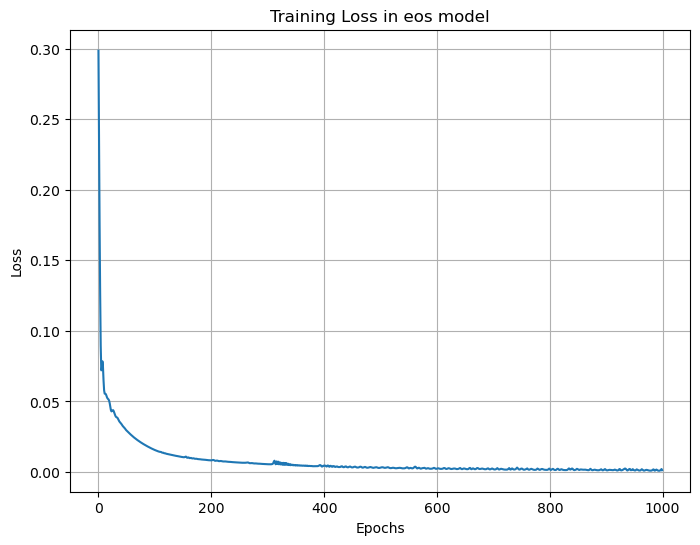

In [7]:
# Load dataset saved with np.savez
data = np.load("EOS_dataset.npz")

# Extract columns
log_pc = data['log_pc_samples']             # shape: (N,)
valid_EOS_params = data['valid_EOS_params'] # shape: (N, 2)
MRL_data = data['MRL_data']                 # shape: (N, 3)

# Prepare X (features) and y (targets)
X_eos = torch.tensor(np.column_stack([log_pc, valid_EOS_params]), dtype=torch.float32)  # pc, L, Ksym
y_eos = torch.tensor(MRL_data[:, :2], dtype=torch.float32)  # Mass, Radius (target)


# Normalize the dataset
X_eos_mean, X_eos_std = X_eos.mean(dim=0), X_eos.std(dim=0)
y_eos_mean, y_eos_std = y_eos.mean(dim=0), y_eos.std(dim=0)
X_eos_norm = (X_eos - X_eos_mean) / X_eos_std
y_eos_norm = (y_eos - y_eos_mean) / y_eos_std

# Split into training and validation sets
train_size = int(0.8 * len(X_eos_norm))
X_eos_train, X_eos_val = X_eos_norm[:train_size], X_eos_norm[train_size:]
y_eos_train, y_eos_val = y_eos_norm[:train_size], y_eos_norm[train_size:]

# Define Neural Network for EOS predictions
class HybridPP_EOS_NN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=50, output_dim=2):
        super(HybridPP_EOS_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize and train the model
model_eos = HybridPP_EOS_NN()
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model_eos.parameters(), lr=0.01)

# Training
epochs = 1000
losses = []
for epoch in range(epochs):
    model_eos.train()
    optimizer.zero_grad()
    outputs = model_eos(X_eos_train)
    loss = criterion(outputs, y_eos_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss in eos model")
plt.grid()
plt.show()


# Save trained model
torch.save(model_eos.state_dict(), "hybridPP_nn_model.pth")

<>:86: SyntaxWarning: invalid escape sequence '\o'
<>:86: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_515132/76972726.py:86: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass (M$_\odot$)")


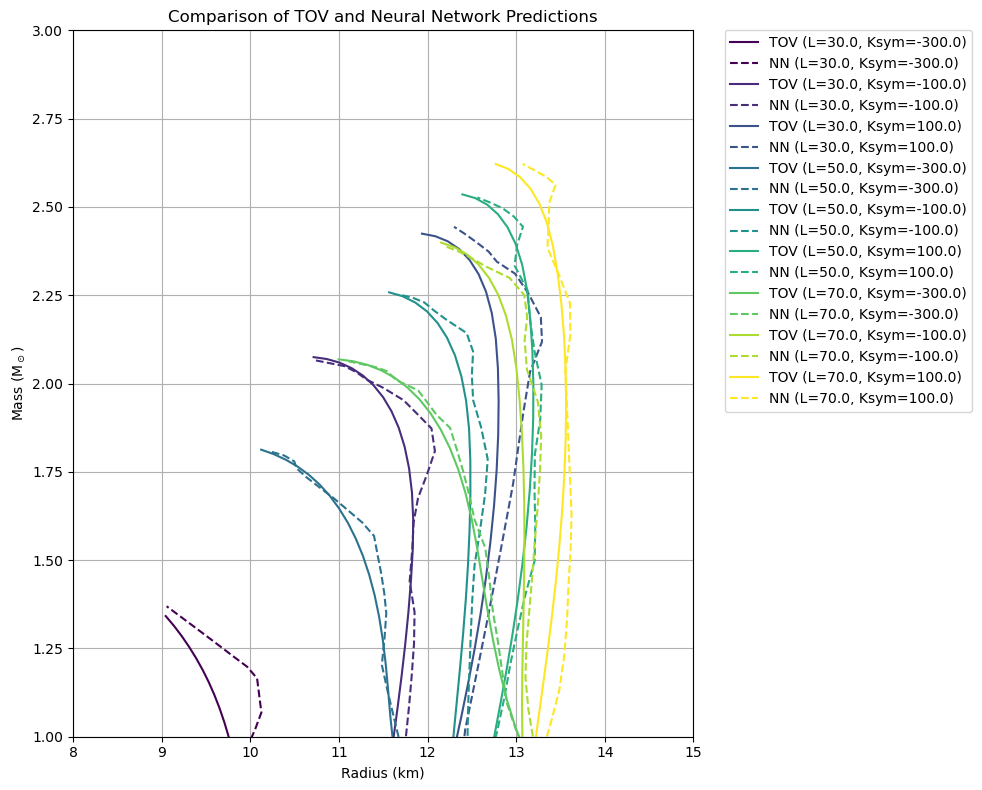

In [8]:
num_points = 50
# Prepare ranges for L and Ksym
L_values = [30., 50., 70.]  
Ksym_values = [-300., -100., 100.]  

# Initialize lists to store results
predicted_mass = []
predicted_radius = []
original_mass = []
original_radius = []

# Iterate over all L and Ksym values
for L in L_values:
    for Ksym in Ksym_values:
        # Store results for this L and Ksym combination
        predicted_mass_single = []
        predicted_radius_single = []
        original_mass_single = []
        original_radius_single = []

        ee, pp, nb, cs, icc = EoS([L, Ksym])
        # Check conditions
        if icc == 0 and max(pp) > pcmin:
            # Create pressure grid
            pc_array = np.logspace(np.log10(pcmin), np.log10(max(pp)), num_points)
            
            # Calculate original mass and radius using TOV
            M_orig, R_orig = get_MR_pc([L, Ksym], pc_array)

            # Convert to NumPy arrays for element-wise operations
            M_orig = np.array(M_orig)
            R_orig = np.array(R_orig)

            # Find first maxima in mass array
            j, mmax = find_first_maxima(M_orig)
        
            # Slice and convert to log10
            pc_array = pc_array[:j]
            log_pc_array = np.log10(pc_array)
            M_orig = M_orig[:j]
            R_orig = R_orig[:j]

            # Prepare input for each pc point: [log_pc, L, Ksym]
            input_array = np.column_stack([
                            log_pc_array,
                            np.full_like(log_pc_array, L),
                                np.full_like(log_pc_array, Ksym)
                                            ])
            
            input_tensor = torch.tensor(input_array, dtype=torch.float32)

            
            # Normalize the input data using the training mean and std
            input_norm = (input_tensor - X_eos_mean) / X_eos_std
            
            # Make predictions with the trained model
            with torch.no_grad():
                prediction = model_eos(input_norm)
            
            # Convert the prediction tensor to NumPy and denormalize the predicted mass and radius
            # Get all predictions
            prediction_np = prediction.detach().numpy()  # shape: (N, 2)

            # Denormalize each column
            mass_pred = prediction_np[:, 0] * y_eos_std[0].item() + y_eos_mean[0].item()
            radius_pred = prediction_np[:, 1] * y_eos_std[1].item() + y_eos_mean[1].item()

            # After iterating over pc, store the results for each kappa, gamma pair
            predicted_mass.append(mass_pred)
            predicted_radius.append(radius_pred)
            original_mass.append(M_orig)
            original_radius.append(R_orig)

plt.figure(figsize=(10, 8))

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values) * len(Ksym_values)))

# Iterate and assign the same color to TOV and NN prediction
for i, (L, Ksym) in enumerate([(k, g) for k in L_values for g in Ksym_values]):
    color = colors[i]
    plt.plot(original_radius[i], original_mass[i], label=f"TOV (L={L}, Ksym={Ksym})", linestyle='-', color=color)
    plt.plot(predicted_radius[i], predicted_mass[i], label=f"NN (L={L}, Ksym={Ksym})", linestyle='--', color=color)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.xlim(8, 15)
plt.ylim(1, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Comparison of TOV and Neural Network Predictions")
plt.grid()
plt.tight_layout()
plt.show()